In [1]:
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Use logarithmic scales?
LOGY=True

# Select countries
#selcnt = ['Poland','Sweden','United Kingdom', 'US', 'Norway', 'Germany']
selcnt = ['Poland','Sweden','US','Germany','Norway','Italy','Spain']
#selcnt = ['Poland', 'Germany', 'Sweden', 'Norway', 'Korea, South', 'China', 'US']
#selcnt = ['Poland', 'Germany', 'Sweden', 'Norway', 'China', 'US']
selcnt = ['Poland', 'Slovakia', 'Germany', 'Czechia', 'Ukraine', 'Belarus', 'Russia']
#selcnt = ['Poland', 'Germany','Sweden','US','Norway','Italy','Spain']
#selcnt = ['Germany','Norway','Italy','Spain']
#selcnt = ['Poland', 'Sweden', 'US', 'Norway']

In [3]:
# Prepare the data

def fix_names(c):
    '''
    Fix differences in naming in datasets
    '''
    mapa = {'Korea, Rep.':'Korea, South',
            'United States':'US',
            'Slovak Republic':'Slovakia',
            'Czech Republic':'Czechia',
            'Russian Federation':'Russia'
           }
    rmap = {v:k for k,v in mapa.items()}
    if c in mapa:
        return mapa[c]
    elif c in rmap:
        return rmap[c]
    else :
        return c


pop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')

selcnt = [fix_names(c) for c in selcnt]

populations = {fix_names(c):n for c, _, _, n in 
                   pop[pop['Country Name'].isin(selcnt) & (pop.Year==2018)].values}

selcnt = [fix_names(c) for c in selcnt]

# Section 2 - Loading and Selecting Data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])

countries = list(populations.keys())
df = df[df['Country'].isin(countries)]
v = df.copy()

# Section 3 - Creating a Summary Column
df['Cases'] = df[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)

# Section 4 - Restructuring our Data
df = df.pivot(index='Date', columns='Country', values='Cases')
countries = list(df.columns)
covid = df.reset_index('Date')
covid.set_index(['Date'], inplace=True)
covid.columns = countries

percapita = covid.copy()
for country in percapita:
    percapita[country] = percapita[country]/populations[country]*100000

rel = covid.pct_change()

v = v.pivot(index='Date', columns='Country', values='Deaths')
vict = v.reset_index('Date')
vict.set_index(['Date'], inplace=True)
vict.columns = countries

victperc = vict.copy()
for country in victperc:
    victperc[country] = victperc[country]/populations[country]*100000

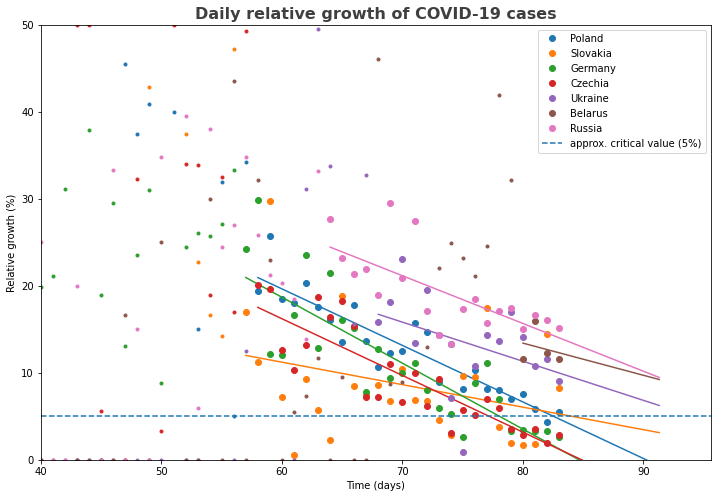

In [4]:
fig = plt.figure(figsize=(12,8))


for c in selcnt:
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    regr.fit(t[mm].reshape(-1,1), rel[c].values[mm])
    p = plt.plot(t[m], 100*rel[c].values[m], '.')[0]
    plt.plot(t[mm], 100*rel[c].values[mm], 'o', color=p.get_color(), label=c)
    x = linspace(t[mm][-s:].min(), 1.1*t[mm][-s:].max(), 100)
    plt.plot(x, 100 * regr.predict(x.reshape(-1,1)), color=p.get_color())
plt.axhline(5, ls='--', label='approx. critical value (5%)')
plt.ylim(0,50)
plt.xlim(40, None)
plt.title('Daily relative growth of COVID-19 cases', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Relative growth (%)')
plt.xlabel('Time (days)')
plt.legend();

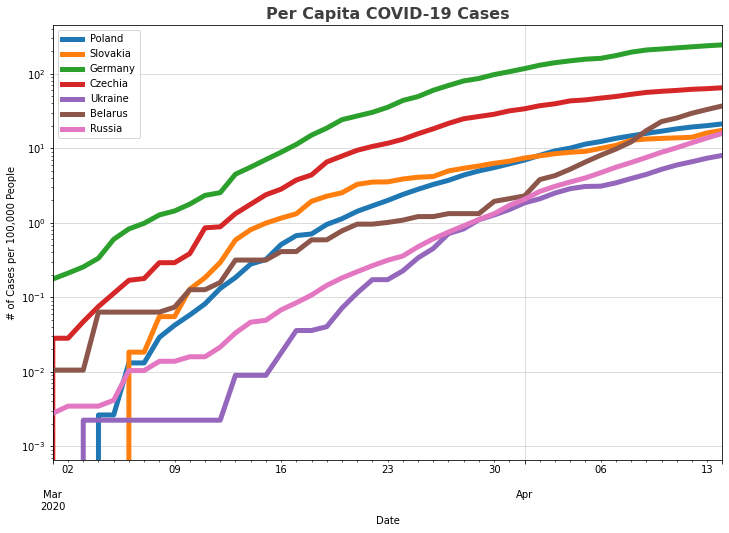

In [5]:
percapitaplot = percapita[selcnt].plot(figsize=(12,8), linewidth=5, logy=LOGY)
percapitaplot.grid(color='#d4d4d4')
percapitaplot.set_xlabel('Date')
percapitaplot.set_ylabel('# of Cases per 100,000 People')
percapitaplot.set_xlim(pd.Timestamp('2020-03-1'),None)
percapitaplot.set_title("Per Capita COVID-19 Cases", 
                        fontsize = 16, weight = 'bold', alpha = .75);

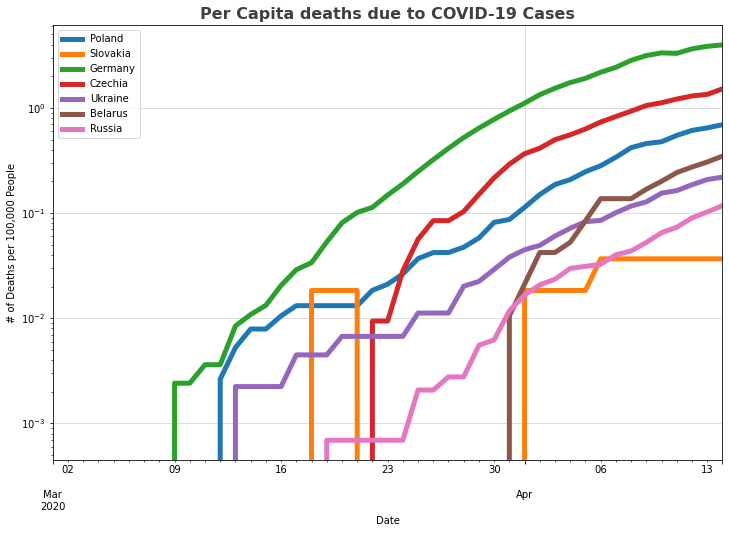

In [6]:
vplot = victperc[selcnt].plot(figsize=(12,8), linewidth=5, logy=LOGY)
vplot.grid(color='#d4d4d4')
vplot.set_xlabel('Date')
vplot.set_ylabel('# of Deaths per 100,000 People')
vplot.set_xlim(pd.Timestamp('2020-03-1'),None)
vplot.set_title("Per Capita deaths due to COVID-19 Cases", fontsize = 16, weight = 'bold', alpha = .75);

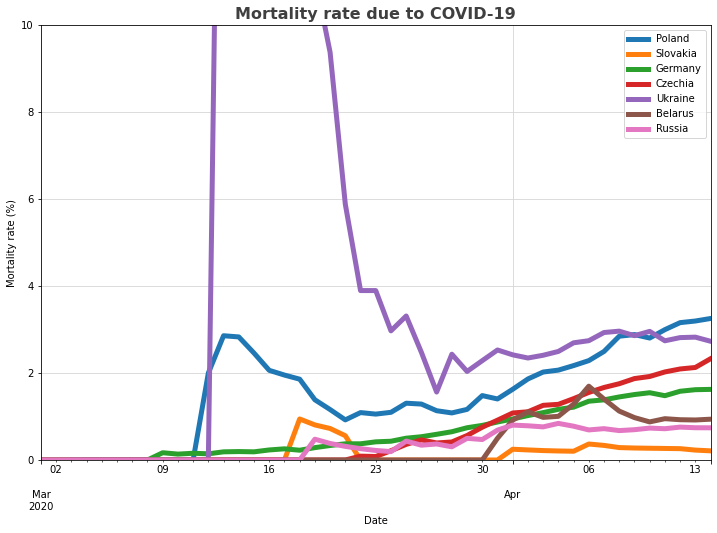

In [7]:
mortplt = (100*victperc[selcnt]/percapita[selcnt]).plot(figsize=(12,8), linewidth=5, logy=False)
mortplt.grid(color='#d4d4d4')
mortplt.set_xlim(pd.Timestamp('2020-03-1'),None)
mortplt.set_ylim(0, 10)
mortplt.set_xlabel('Date')
mortplt.set_ylabel('Mortality rate (%)')
mortplt.set_title('Mortality rate due to COVID-19', fontsize = 16, weight = 'bold', alpha = .75);

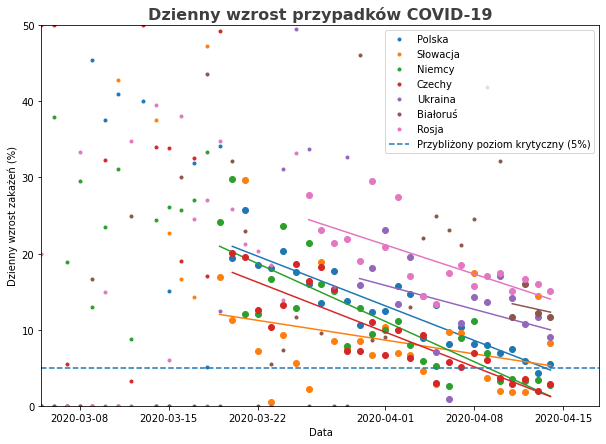

In [9]:
fig = plt.figure(figsize=(10,7))

def plleg(c):
    pl = {
        'Poland':'Polska', 
        'Slovakia': 'Słowacja', 
        'Germany': 'Niemcy',
        'Czechia': 'Czechy',
        'Ukraine': 'Ukraina', 
        'Belarus': 'Białoruś', 
        'Russia': 'Rosja'
    }
    if c in pl:
        return pl[c]
    else :
        return c
    
ax = gca()
for n, c in enumerate(selcnt):
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    t = rel.index.to_pydatetime()
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    x = arange(rel.index.size)
    fit = polyfit(x[mm], rel[c].values[mm], 1)
    p = plt.plot(rel.index[m], 100*rel[c].values[m], '.', label=plleg(c))[0]
    plt.plot(rel.index[mm], 100*rel[c].values[mm], 'o', color=p.get_color())
    plt.plot(rel.index[mm], 100 * polyval(fit, x[mm]), color=p.get_color())

plt.axhline(5, ls='--', label='Przybliżony poziom krytyczny (5%)')
plt.ylim(0,50)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title('Dzienny wzrost przypadków COVID-19', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Dzienny wzrost zakażeń (%)')
plt.xlabel('Data')
plt.legend()
plt.savefig('wzrosty_dzienne.png');